# Thick YIG film - spin-wave hybridization
- notebook used for the results published in C.Riedel, et al., Hybridization‐Induced Spin‐Wave Transmission Stop Band within a 1D Diffraction Grating, Advanced Physics Research, https://onlinelibrary.wiley.com/doi/10.1002/apxr.202200104
- in this notebook we would like to show you the possibility how to obtain the resonance fields for a well-defined frequency in function of the wave vectors

In [1]:
import tetrax as tx
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

### Analytics: Kalinikos - Slavin equation
- the function omega computes the dispersion for both backward volume (BVM) and Daemon-Eshbach (SW) geometry by giving the proper keyword as an input to the function at call

In [2]:
def omega(k, gamma, M_s, A, T, B_0=0, kind="BVW", n=0, mu_0=4*np.pi*1e-7):
    omega_M = gamma * mu_0 * M_s
    omega_0 = gamma * B_0
    Lambda = np.sqrt(2*A / (mu_0 *M_s**2))


    k_n = np.sqrt(k**2 + (n*np.pi/T)**2)

    rat = k**2 / k_n**2
    kron_n = (n == 0)
    P_nn = rat*(1 - (2/(1+kron_n))*rat*(1-(-1)**n *np.exp(-k*T))/(k*T))
    if kind == "BVW":
        return np.sqrt(
            (omega_0 + omega_M* Lambda**2 * k_n**2) *\
                (omega_0 + omega_M* Lambda**2 *k_n**2 + omega_M*(1-P_nn))
        )
    if kind == "SW":
        return np.sqrt(
            (omega_0 + omega_M * Lambda**2 *k_n**2 + omega_M*P_nn) *\
                (omega_0 + omega_M* Lambda**2 *k_n**2 + omega_M*(1-P_nn))
        )
    else:
        print("No valid spin wave kind specified in dispersion. "
              "Please use BVW or SW.")
        return k*0

### Field versus wave vector derived from the analytical Kalinikos-Slavin equation

In [3]:
def Bext_KS(k, gamma, M_s, A, T, omega, n=0, mu_0=4*np.pi*1e-7):
    omega_M = gamma * mu_0 * M_s
    Lambda = np.sqrt(2*A / (mu_0 *M_s**2))
    k_n = np.sqrt(k**2 + (n*np.pi/T)**2)
    rat = k**2 / k_n**2
    kron_n = (n == 0)
    P_nn = rat*(1 - (2/(1+kron_n))*rat*(1-(-1)**n *np.exp(-k*T))/(k*T))

    b = omega_M * (2 * Lambda**2 * k_n**2 + 1)
    delta = np.sqrt(omega_M**2 + 4*omega**2 - 4*omega_M**2*P_nn*(1-P_nn))
    return np.abs((-b+delta)/(2*gamma))

### Numerical dispersion calculation

- we create a YIG film with 200 nm thickness and a line trace mesh along the thickness with 5 nm resolution

- NOTE: the thickness direction is the y direction, propagation direction is the z direction.

In [4]:
T = 200
Msat = 139.6e3
Aex = 4.0e-12
sample = tx.create_sample(geometry="layer",name="Level_crossing")
msh = tx.geometries.monolayer_line_trace(T,5)
sample.set_geom(msh)
sample.Msat = Msat
sample.Aex = Aex

Setting geometry and calculating discretized differential operators on mesh.
Done.


### To have a feeling about the dispersion we compute it first for a given applied field

In [5]:
Bext = 35e-3
sample.mag = [1,0,0]
exp = tx.create_experimental_setup(sample,name="DE-geometry")
exp.Bext = [Bext,0,0]
disp = exp.eigenmodes(kmin=0e6,kmax=5e6,Nk=201,num_modes=3,num_cpus=-1,save_modes=False, fname="disp_35mT.csv")

100%|███████████████████████████| 201/201 [00:25<00:00,  7.80it/s]


### and we plot it together with the analytical dispersion

<IPython.core.display.Javascript object>


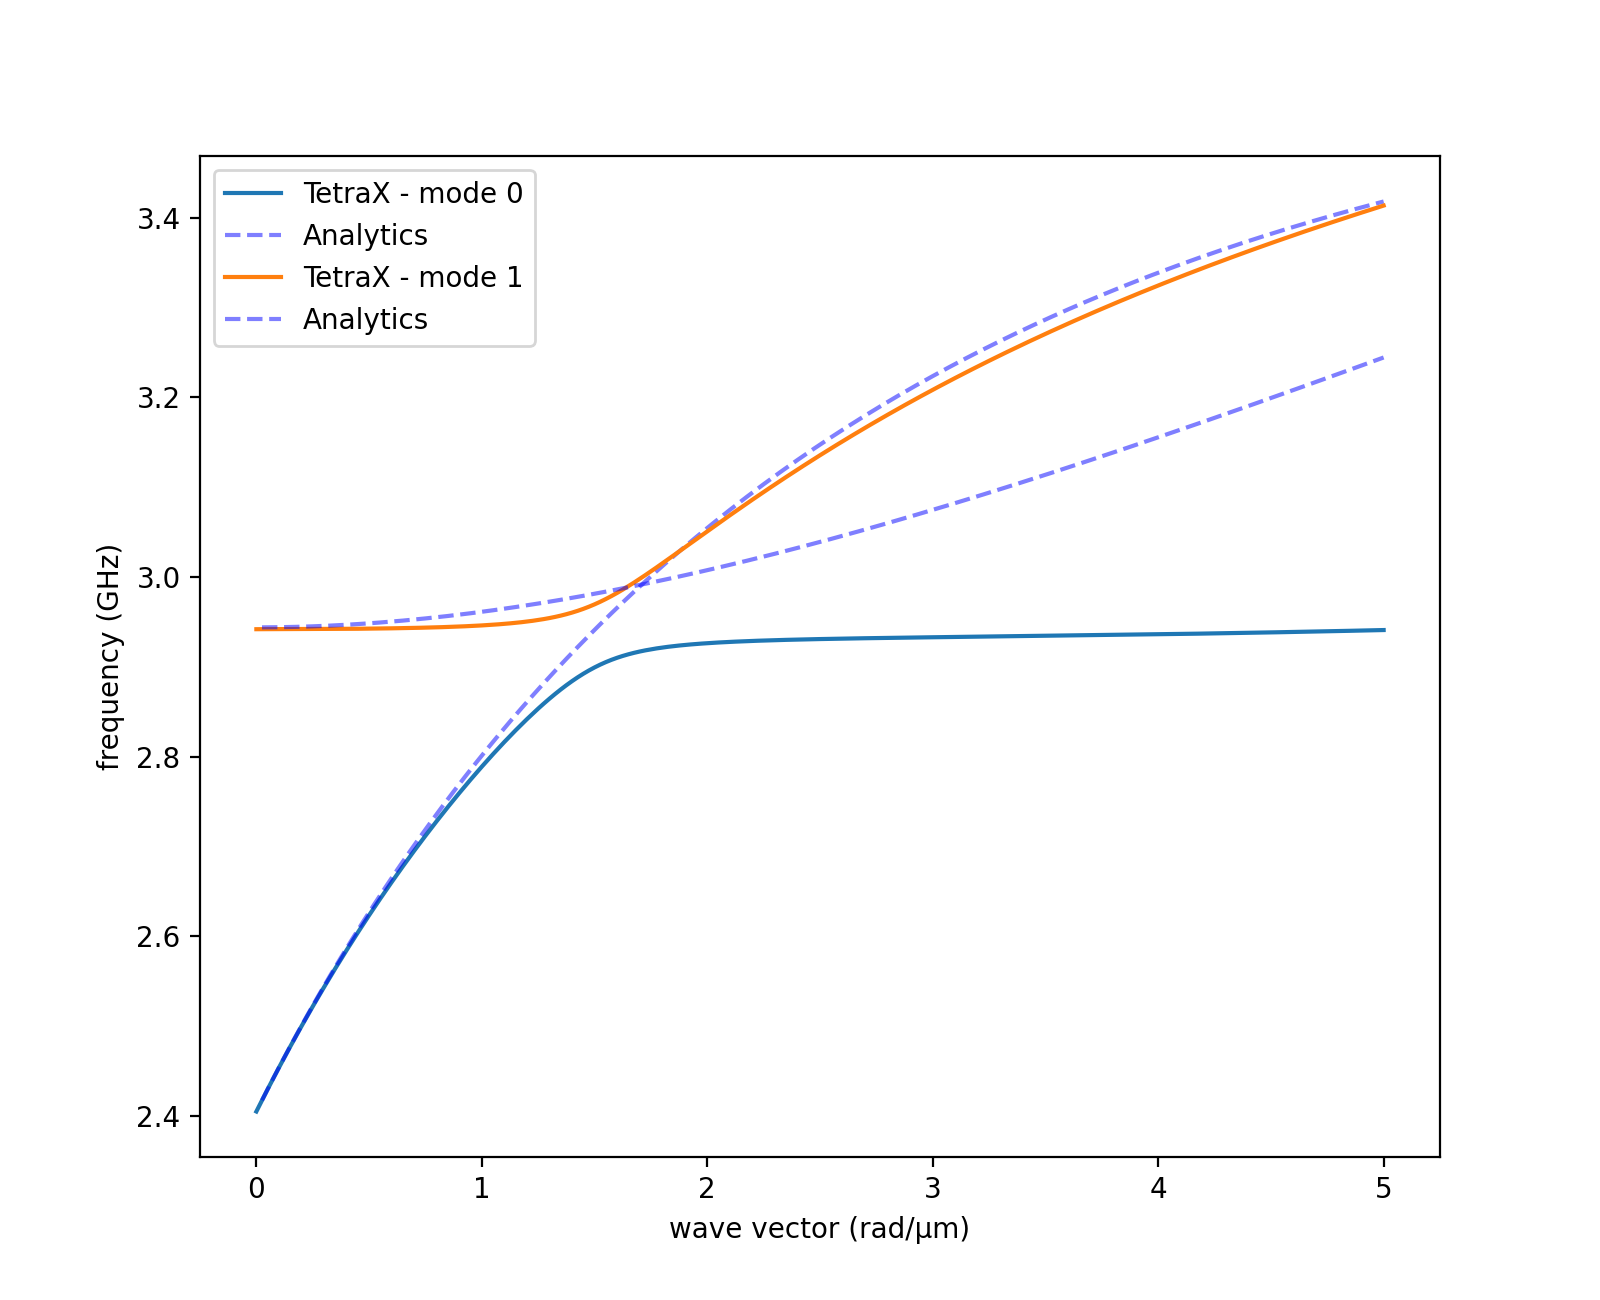

In [6]:
kdp = disp["k (rad/m)"]

plt.rcParams["figure.figsize"] = (8,6.5)

plt.figure()
for i in range(2):
    plt.plot(kdp*1e-6,disp[f"f{i} (GHz)"],ls="-",label=f"TetraX - mode {i}")
    plt.plot(kdp*1e-6,omega(np.abs(kdp), sample.gamma, Msat, Aex, T*1e-9, Bext, kind="SW", n=i, mu_0=4*np.pi*1e-7)/(2*np.pi*1e9),ls="--",marker="",alpha=0.5,c="b",label="Analytics")


plt.xlabel("wave vector (rad/µm)")
plt.ylabel("frequency (GHz)")
plt.legend()
plt.show()

### Here we define the external field values as an array and for every single field value we calculate the dispersion

- the field loop is devided in three parts, the middle region has a higher resolution for better resolving the "Level crossing" of the different spin-wave branches
- PLEASE be patient, this will take a while... many dispersions to be calculated. Even TetraX can be slow... time to time. :-D

In [7]:
Bext_ = 1e-3*np.concatenate((np.arange(26,30,0.5),np.arange(30,34,0.05),np.arange(34,39,0.5))) # fields in Tesla
angle = 0

f0 = []
f1 = []
f2 = []

for Bext in Bext_:
#    print(Bext)
    exp.Bext = [Bext*np.cos(angle*np.pi/180),0,Bext*np.sin(angle*np.pi/180)]
    dispersion = exp.eigenmodes(kmin=0.8e6,kmax=2.2e6,Nk=81,num_modes=3,num_cpus=-1,save_modes=False,verbose=False)
    f0.append(dispersion["f0 (GHz)"].values)
    f1.append(dispersion["f1 (GHz)"].values)
    f2.append(dispersion["f2 (GHz)"].values)    

### Interpolation/extrapolation is used to couple the frequencies with fields 

- For every single field value we need to find the $k_0$ and $k_1$ so that $f_0(k_0) = f_{RF} = 2.8\ \mathrm{GHz}$ and $f_1(k_1) = f_{RF} = 2.8\ \mathrm{GHz}$, respectively. NOTE: an extrapolation will be used!

In [8]:
from scipy.interpolate import interp1d

k_ = dispersion["k (rad/m)"]
f0 = np.array(f0)
f1 = np.array(f1)
f2 = np.array(f2)

k0 = []
k1 = []
k2 = []


f_RF = 2.8 # GHz
for i, Bext in enumerate(Bext_):
    f0_B = f0[i]
    f1_B = f1[i]
    f2_B = f2[i]
    k0.append(interp1d(f0_B, k_,fill_value="extrapolate")(f_RF))        
    k1.append(interp1d(f1_B, k_,fill_value="extrapolate")(f_RF))
    k2.append(interp1d(f2_B, k_,fill_value="extrapolate")(f_RF))


k0 = np.array(k0)
k1 = np.array(k1)
k2 = np.array(k2)

### Let's plot the results together with the analytical values from the Kalinikos-Slavin derivation

<IPython.core.display.Javascript object>


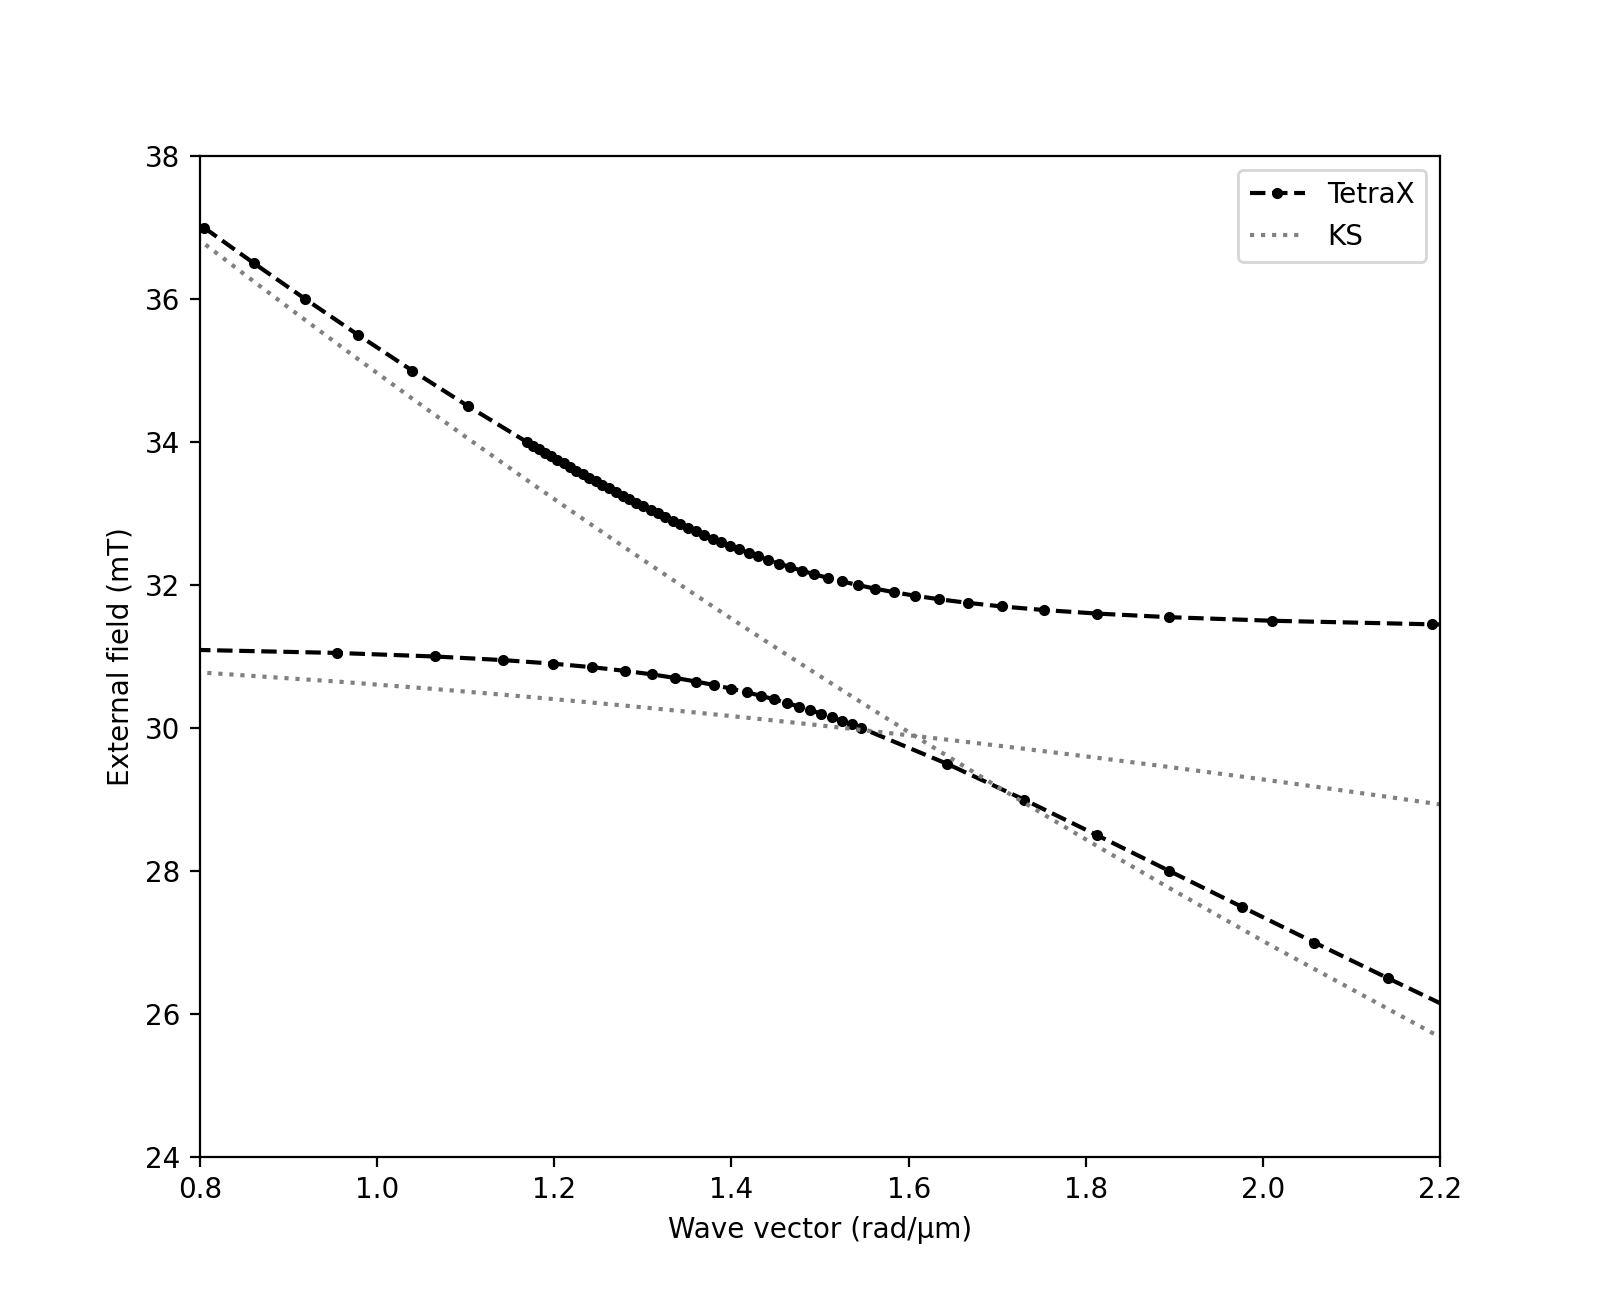

In [9]:
plt.rcParams["figure.figsize"] = (8,6.5)
plt.figure()

# numerical results from the extrapolation
plt.plot(1e-6*k0,Bext_*1e3,ls="--", marker=".",c="k", label = "TetraX")
plt.plot(1e-6*k1,Bext_*1e3,ls="--",marker=".", c="k")
#plt.plot(1e-6*k2,Bext_*1e3,ls="--",marker=".", c="r")

# analytical values using the Bext_KS function defined above
plt.plot(k0*1e-6,Bext_KS(k0, sample.gamma, Msat, Aex, T*1e-9, 2*np.pi*2.8e9, 0, 4*np.pi*1e-7)*1000,ls=":",color="grey",label="KS")
plt.plot(k1*1e-6,Bext_KS(k1, sample.gamma, Msat, Aex, T*1e-9, 2*np.pi*2.8e9, 1, 4*np.pi*1e-7)*1000,ls=":",color="grey")


plt.xlim([0.8,2.2])
plt.ylim([24,38])
plt.xlabel("Wave vector (rad/µm)")
plt.ylabel("External field (mT)")
plt.legend()

### One can save the obtained data as pandas dataframe

In [10]:
import pandas as pd
d = {"k0 [rad/m]": k0, "k1 [rad/m]": k1, "Bext [T]": Bext_}
B_vs_k_200nm = pd.DataFrame(data=d)
B_vs_k_200nm.to_csv("Level_crossing/B_vs_k_200nm.csv")